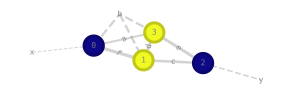

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [134]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg

inputs = [
    ('a', 'b', 'x', 'f'), 
    ('b', 'c', 'd', 'f'), 
    ('c', 'e', 'y'), 
    ('e', 'a', 'd', 'b'),
]

output = ('x', 'y')

size_dict = {'x': 2, 'y': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f' : 9}

ctg.HyperGraph(inputs, output, size_dict).plot()

In [139]:
from cotengra.hypergraph import HyperGraph

def modularitygain (edge, edges, nodes, weights, vol, volall):
    clusters = set(edges[edge])
    commonedges = [] 
    for e in nodes[next(iter(clusters))]:
        if set(edges[e]).issubset(clusters) and len(set(edges[e])) > 1 : commonedges.append(e)
    gain = sum([weights['edge_weight_map'][e] for e in commonedges]) + sum([degs[d]*(sum([vol[cluster] ** d for cluster in clusters])-sum([vol[cluster] for cluster in clusters]) ** d)/(volall ** d) for d in range(2, len(degs))])
    return gain, commonedges


def maxmodularitygain(edges, nodes, weights, vol, volall):
    maxgain = None
    maxedges = None
    for edge in edges:
        gain, commonedges = modularitygain(edge, edges, nodes, weights, vol, volall)
        if maxgain == None or gain > maxgain:
            maxgain = gain
            maxedges = commonedges
    return maxgain, maxedges

hg = HyperGraph(inputs, output, size_dict)
for edge in output: hg.remove_edge(edge)
n = hg.get_num_nodes()
m = hg.get_num_edges()


edges = hg.edges.copy()
nodes = hg.nodes.copy()
weights = hg.compute_weights(weight_nodes="log", weight_edges="log")
vol = {k:v for k,v in enumerate(weights['node_weights'])}
volall = sum(vol.values())
degs = [0 for _ in range(n)]
for k, v in hg.edges.items():
    if len(v) != 1: degs[len(v)] += weights['edge_weight_map'][k]


print(edges)
print(nodes)
print(weights)
print(degs)


while len(edges) > 1:
    #compute contraction
    gain, contractionedges = maxmodularitygain(edges, nodes, weights, vol, volall)
    if gain >= 0 or len(nodes) >= 16:
        clusterset = set.union(*[set(edges[edge]) for edge in contractionedges])
        clusteredges = set.union(*[set(nodes[node]) for node in clusterset]).difference(set(contractionedges))
        #delete intra cluster edges
        for contractionedge in contractionedges: edges.pop(contractionedge)
        it = iter(clusterset)
        clusternode = next(it)
        #update cluster node
        nodes.update({clusternode : clusteredges})
        print(clusternode)
        for node in it:
            print(node)
            nodes.pop(node)
        #update vol
        vol[clusternode] = sum([vol[i] for i in clusterset])
        #update surrounding edges
        edges.update({edge : tuple(map(lambda x: clusternode if x in clusterset else x,list(edges[edge]))) for edge in clusteredges})
        #todo track clusters
    else:
        break

{'a': (0, 3), 'b': (0, 1, 3), 'f': (0, 1), 'c': (1, 2), 'd': (1, 3), 'e': (2, 3)}
{0: ('a', 'b', 'f'), 1: ('b', 'c', 'd', 'f'), 2: ('c', 'e'), 3: ('e', 'a', 'd', 'b')}
{'node_weights': (7491, 10884, 5584, 10129), 'edge_list': ('a', 'b', 'f', 'c', 'd', 'e'), 'edge_weight_map': {'a': 2001, 'b': 2322, 'f': 3170, 'c': 2585, 'd': 2808, 'e': 3001}, 'edge_weights': (2001, 2322, 3170, 2585, 2808, 3001), 'has_edge_weights': True, 'has_node_weights': True, 'fmt': '11'}
[0, 0, 13565, 2322]
2
3
['e']
{'a': (0, 2), 'b': (0, 1, 2), 'f': (0, 1), 'c': (1, 2), 'd': (1, 2)}
{0: ('a', 'b', 'f'), 1: ('b', 'c', 'd', 'f'), 2: {'d', 'a', 'c', 'b'}}
0
1
['f']
{'a': (0, 2), 'b': (0, 0, 2), 'c': (0, 2), 'd': (0, 2)}
{0: {'d', 'a', 'c', 'b'}, 2: {'d', 'a', 'c', 'b'}}
